In [ ]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline


# 空间变换器网络
**Author**: [Ghassen HAMROUNI](https://github.com/GHamrouni)

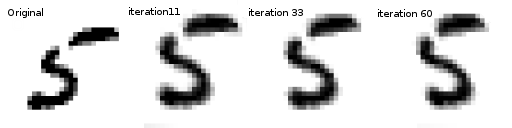

在本教程中，您将学习如何使用称为空间变换器网络的视觉注意机制来扩充您的网络。你可以在DeepMind paper 阅读更多有关空间变换器网络的内容。 [DeepMind paper](https://arxiv.org/abs/1506.02025)_

空间变换器网络是对任何空间变换的差异化关注的概括。空间变换器网络（简称STN）允许神经网络学习如何在输入图像上执行空间变换， 以增强模型的几何不变性。例如，它可以裁剪感兴趣的区域，缩放并校正图像的方向。而这可能是一种有用的机制，因为CNN对于旋转和 缩放以及更一般的仿射变换并不是不变的。

关于STN的最棒的事情之一是能够简单地将其插入任何现有的CNN，而且只需很少的修改。


In [1]:
# License: BSD
# Author: Ghassen Hamrouni

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

plt.ion()   # interactive mode

/opt/anaconda3/envs/learning-in-general/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading the data

在这篇文章中，我们尝试了经典的 MNIST 数据集。使用标准卷积网络增强空间变换器网络。



In [3]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='../../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=64, shuffle=True, num_workers=4)
# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='../../data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)

## Depicting spatial transformer networks

空间变换器网络归结为三个主要组成部分：

- 本地网络（Localisation Network）是常规CNN，其对变换参数进行回归。不会从该数据集中明确地学习转换，而是网络自动学习增强 全局准确性的空间变换。
- 网格生成器( Grid Generator)在输入图像中生成与输出图像中的每个像素相对应的坐标网格。
- 采样器（Sampler）使用变换的参数并将其应用于输入图像。

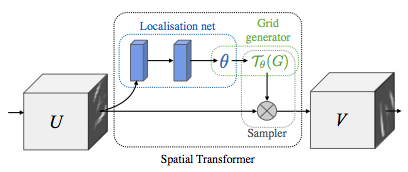

<div class="alert alert-info"><h4>Note</h4><p>We need the latest version of PyTorch that contains
   affine_grid and grid_sample modules.</p></div>




In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function, 常规CNN localization， 网络生成器，采样器
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


model = Net().to(device)

## Training the model

训练模型 现在我们使用 SGD（随机梯度下降）算法来训练模型。网络正在以有监督的方式学习分类任务。同时，该模型以端到端的方式自动学习STN。



In [5]:
optimizer = optim.SGD(model.parameters(), lr=0.01)


def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
#
# A simple test procedure to measure the STN performances on MNIST.
#


def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))

## Visualizing the STN results

可视化学习结果。

定义一个小点的帮助函数来可视化训练中的转换。




/opt/anaconda3/envs/learning-in-general/lib/python3.10/site-packages/torch/nn/functional.py:4358: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/opt/anaconda3/envs/learning-in-general/lib/python3.10/site-packages/torch/nn/functional.py:4296: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.317123
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.900415

Test set: Average loss: 0.2904, Accuracy: 9123/10000 (91%)



/opt/anaconda3/envs/learning-in-general/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 2 [0/60000 (0%)]	Loss: 0.433040
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.409859

Test set: Average loss: 0.1305, Accuracy: 9622/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.543992
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.275914

Test set: Average loss: 0.0884, Accuracy: 9727/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.300720
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.101902

Test set: Average loss: 0.0948, Accuracy: 9695/10000 (97%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.225663
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.159484

Test set: Average loss: 0.0777, Accuracy: 9762/10000 (98%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.151924
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.165921

Test set: Average loss: 0.0728, Accuracy: 9771/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.228410
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.444090

Test set: Average loss: 0.0938, Accuracy: 9719/10000 (97%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.133852
Train Epoch: 8 [320

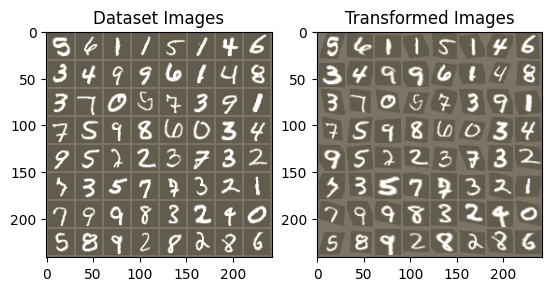

In [6]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

for epoch in range(1, 20 + 1):
    train(epoch)
    test()

# Visualize the STN transformation on some input batch
visualize_stn()

plt.ioff()
plt.show()